In [1]:
import itertools as it
from matplotlib import gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pennylane as qml
import qutip
import scipy as sp
from tqdm.auto import tqdm
import pandas as pd

/lustre/home/acct-seeyjc/seeyjc-tyh/.conda/envs/gqs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from read_data import load_test_data
import argparse
parser = argparse.ArgumentParser()
parser.add_argument('--dataset', type=str, default='ppt', choices=['train', 'valid', 'test'], help='dataset split used to decode')
parser.add_argument('--data_dir', type=str, default='N_10_NM_1000_S_20', help='path to the folder of diffusion model')
parser.add_argument('--seed', type=int, default=101, help='random seed')

parser.add_argument('--num_measurements', type=int, default=1000, help='batch size')
parser.add_argument('--num_qubits', type=int, default=10, help='batch size')
# parser.add_argument('--split', type=str, default='train', choices=['train', 'valid', 'test'], help='dataset split used to decode')
# parser.add_argument('--shots', type=int, default=1000, help='number of shots for generation')
args, unknown = parser.parse_known_args()

num_measurements = args.num_measurements
num_qubits = args.num_qubits

true_data = load_test_data(args, num_measurements=num_measurements)
print(true_data["input_ids"].shape, true_data["conditions"].shape)

############################## 
Loading test dataset from N_10_NM_1000_S_20...
### Total number of samples: 20
### The dimension of conditions: 9
### The number of qubits: 10
### Data samples...
 [[1.82 0.98 1.3  0.16 1.87 1.56 1.31 1.68 0.47]
 [0.36 1.53 0.18 1.6  1.54 0.17 0.41 0.06 0.17]] 
 [[5 3 4 5 0 5 3 0 4 2]
 [5 2 5 0 1 5 1 0 5 4]]
(20, 1000, 10) (20, 9)


In [3]:
def load_coupling_matrix(path):
    coupling_strength = pd.read_csv(path, header=None).to_numpy().reshape(-1)
    rows = 1
    cols = len(coupling_strength)+1

    qubits = rows * cols
    
    # Create a 2D Lattice
    edges = [
        (si, sj) for (si, sj) in it.combinations(range(qubits), 2)
        if ((sj % cols > 0) and sj - si == 1) or sj - si == cols
    ]
    
    # sample edge weights uniformly at random from [0, 2]
    edge_weights = coupling_strength

    coupling_matrix = np.zeros((qubits, qubits))
    for (i, j), w in zip(edges, edge_weights):
        coupling_matrix[i, j] = coupling_matrix[j, i] = w
        
    return coupling_matrix

In [4]:
num_qubits = 10
path = './samples/diffuseq_qqp_h128_lr0.0001_t2000_sqrt_lossaware_seed102_test-qqp20240516-18_16_48/ema_0.9999_050000.pt.samples/seed123_step0.txt'
samples = np.loadtxt(path,  delimiter=',', dtype=int)
# samples = samples[:, 1:]
samples = samples.reshape(20, -1, num_qubits)
print(samples.shape)

(20, 50000, 10)


In [5]:
def load_coupling_matrix(coupling_strength):
    rows = 1
    cols = len(coupling_strength)+1

    qubits = rows * cols
    
    # Create a 2D Lattice
    edges = [
        (si, sj) for (si, sj) in it.combinations(range(qubits), 2)
        if ((sj % cols > 0) and sj - si == 1) or sj - si == cols
    ]
    
    # sample edge weights uniformly at random from [0, 2]
    edge_weights = coupling_strength

    coupling_matrix = np.zeros((qubits, qubits))
    for (i, j), w in zip(edges, edge_weights):
        coupling_matrix[i, j] = coupling_matrix[j, i] = w
        
    return coupling_matrix

# define the system size and lattice geometry
rows, cols = 1, num_qubits
wires = rows * cols

# sample a coupling matrix
J_list = [load_coupling_matrix(J) for J in true_data['conditions']]
# J_list[0]

In [6]:
J = J_list[8]
results = samples[8].reshape(-1, 10)
J.shape, results.shape

((10, 10), (50000, 10))

In [7]:
# # define the system size and lattice geometry
# rows, cols = 1, 10
# wires = rows * cols

# # sample a coupling matrix
# path = '/mnt/nas/home/tangyehui/src/DiffuSeq/data/N_10_NM_1000_S_20/J/J_1.csv'
# J = load_coupling_matrix(path)
# results = pd.read_csv('/mnt/nas/home/tangyehui/src/DiffuSeq/generation_outputs/diffuseq_qqp_h128_lr0.0001_t2000_sqrt_lossaware_seed102_test-qqp20240516-18:16:48/ema_0.9999_050000.pt.samples/seed123_step0.txt', header=None).to_numpy(dtype=int).reshape(20*50000,10)
# results = results[:50000]
# results[:5]

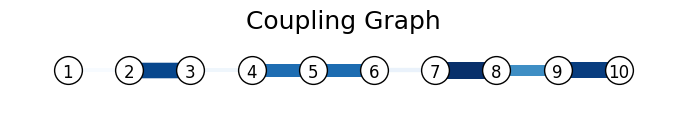

In [8]:
# create graph object
graph = nx.from_numpy_array(np.matrix(J), create_using=nx.DiGraph)
graph = nx.relabel_nodes(graph, {i: i + 1 for i in graph.nodes})
pos = {i: ((i-1) % cols, -((i-1) // cols)) for i in graph.nodes()}

# make edge widths proportional to edge weight
edge_widths = [
    (x + 1.5) ** 2 for x in list(nx.get_edge_attributes(graph, "weight").values())
]

# extract edge weights for colouring
edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())

plt.figure(figsize=(cols / 1.5, rows / 1.5))
nx.draw(
    graph, pos, node_color="white", with_labels=True, font_color="black", edge_cmap=plt.cm.Blues,
    node_size=400, width=edge_widths, horizontalalignment='center', edgecolors="black", edgelist=edges, 
    edge_color=weights, arrows=False, verticalalignment='center_baseline', font_size=12
)
plt.title('Coupling Graph', fontsize=18)
plt.show()

In [9]:
def build_hamiltonian(coupling_matrix):
    coeffs, ops = [], []
    ns = coupling_matrix.shape[0]

    for i, j in it.combinations(range(ns), r=2):
        coeff = coupling_matrix[i, j]
        if coeff:
            for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
                coeffs.append(coeff)
                ops.append(op(i) @ op(j))

    return qml.Hamiltonian(coeffs, ops)

In [10]:
# build sparse hamiltonian
H = build_hamiltonian(J)
H_sparse = qml.utils.sparse_hamiltonian(H)

# diagonalize
eigvals, eigvecs = sp.sparse.linalg.eigs(H_sparse, which='SR', k=1)
eigvals = eigvals.real
ground_state = eigvecs[:, np.argmin(eigvals)]
eigvals, eigvecs

/lustre/home/acct-seeyjc/seeyjc-tyh/.conda/envs/gqs/lib/python3.9/site-packages/pennylane/utils.py:67: UserWarning: The method sparse_hamiltonian is deprecated. Please use the method sparse_matrix of the Hamiltonian operator instead.
  warnings.warn(


(array([-23.69786141]),
 array([[ 3.42392005e-19+4.84197617e-20j],
        [ 2.74901345e-18+1.04486144e-17j],
        [-5.91225264e-18+6.49149908e-19j],
        ...,
        [-2.00668310e-18+2.53854492e-18j],
        [-8.22515107e-18-2.16855988e-18j],
        [ 6.29141430e-19-2.68413475e-19j]]))

In [11]:
# this circuit measures observables for the provided ground state
@qml.qnode(device=qml.device('default.qubit', wires=wires, shots=None))
def circ(observables):
    qml.QubitStateVector(ground_state, wires=range(wires))
    return [qml.expval(o) for o in observables]


def compute_exact_correlation_matrix(ground_state, wires):
    # setup observables for correlation function
    def corr_function(i, j):
        ops = []
        
        for op in [qml.PauliX, qml.PauliY, qml.PauliZ]:
            if i != j:
                ops.append(op(i) @ op(j))
            else:
                ops.append(qml.Identity(i))

        return ops
    
    # indices for sites for which correlations will be computed
    coupling_pairs = list(it.product(range(wires), repeat=2))
    
    # compute exact correlation matrix
    correlation_matrix = np.zeros((wires, wires))
    for idx, (i, j) in tqdm(enumerate(coupling_pairs), total=len(coupling_pairs)):
        observable = corr_function(i, j)

        if i == j:
            correlation_matrix[i][j] = 1.0
        else:
            correlation_matrix[i][j] = (
                    np.sum(np.array([circ(observables=[o]) for o in observable]).T) / 3
            )
            correlation_matrix[j][i] = correlation_matrix[i][j]

    return correlation_matrix

In [12]:
exact_correlation_matrix = compute_exact_correlation_matrix(ground_state, wires)

100%|██████████| 100/100 [00:00<00:00, 149.02it/s]


In [13]:
def plot_eval_matrix(coup_mat, eval_mat, title, cmap, true_mat=None, vmin=-1.0, vmax=1.0):
    num_figures = 2 if true_mat is None else 3 
    fig = plt.figure(figsize=(num_figures * cols + 2, rows))
    gs = gridspec.GridSpec(rows, num_figures * cols, figure=fig)
    
    # plot coupling graph
    ax = fig.add_subplot(gs[:, :cols])
    graph = nx.from_numpy_array(np.matrix(coup_mat), create_using=nx.DiGraph)
    graph = nx.relabel_nodes(graph, {i: i + 1 for i in graph.nodes})
    pos = {i: ((i-1) % cols, -((i-1) // cols)) for i in graph.nodes()}
    edge_widths = [(x + 1.5) ** 2 for x in list(nx.get_edge_attributes(graph, "weight").values())]
    edges, weights = zip(*nx.get_edge_attributes(graph,'weight').items())
    ax.set_title('Coupling Graph', fontsize=16)
    ax.set_aspect('equal')

    nx.draw(
        graph, pos, node_color="white", with_labels=True, font_color="black", edge_cmap=plt.cm.Blues,
        node_size=400, width=edge_widths, horizontalalignment='center', edgecolors="black", edgelist=edges, edge_color=weights,
        arrows=False, ax=ax, verticalalignment='center_baseline', font_size=10
    )
    
    # plot correlation matrix
    tick_locs = np.array([0] + [i for i in np.arange(5, rows * cols, 5) - 1])
    tick_marks = tick_locs + 1
    if true_mat is None:
        ax = fig.add_subplot(gs[:, cols:])
    else:
        ax = fig.add_subplot(gs[:, cols:(2 * cols)])
    im = ax.imshow(eval_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)
    ax = plt.gca()
    ax.xaxis.tick_bottom()
    ax.yaxis.tick_left()
    ax.xaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
    ax.yaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
    ax.set_title(title, fontsize=16)
    ax.set_aspect('equal')

    for _, s in ax.spines.items():
        s.set_color('white')
    
    if true_mat is not None:
        ax = fig.add_subplot(gs[:, (2 * cols):])
        im = ax.imshow(true_mat, cmap=plt.cm.get_cmap(cmap), vmin=vmin, vmax=vmax)
        ax = plt.gca()
        ax.xaxis.tick_bottom()
        ax.yaxis.tick_left()
        ax.xaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
        ax.yaxis.set_ticks(tick_locs, tick_marks, fontsize=12)
        ax.set_title('Ground Truth', fontsize=16)
        ax.set_aspect('equal')
        
        for _, s in ax.spines.items():
            s.set_color('white')

    # colorbar
    bar = fig.colorbar(im, pad=0.01, ax=ax)
    bar.set_label(r'$C_{ij}$', fontsize=12, rotation=0, labelpad=10)
    bar.ax.tick_params(labelsize=12)

    for _, s in bar.ax.spines.items():
        s.set_color('white')

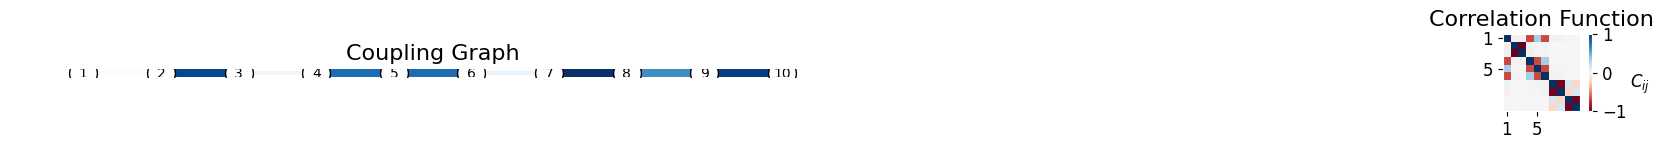

In [14]:
plot_eval_matrix(J, exact_correlation_matrix, title='Correlation Function', cmap='RdBu')

In [15]:
def compute_exact_entropy_matrix(ground_state, wires):
    ground_state_qobj = qutip.Qobj(ground_state, dims=[[2] * wires, [1] * wires])

    # compute entropies
    entropies = np.zeros(shape=(wires, wires), dtype=float)
    for i in tqdm(range(wires)):
        ptrace_diag = ground_state_qobj.ptrace(sel=[i])
        entropies[i, i] = -np.log(np.trace(ptrace_diag * ptrace_diag).real)

        for j in range(i + 1, wires):
            ptrace = ground_state_qobj.ptrace(sel=[i, j])
            e = -np.log(np.trace(ptrace * ptrace).real)
            entropies[i, j] = entropies[j, i] = e

    return entropies
exact_entropy_matrix = compute_exact_entropy_matrix(ground_state, wires)

100%|██████████| 10/10 [00:00<00:00, 469.54it/s]


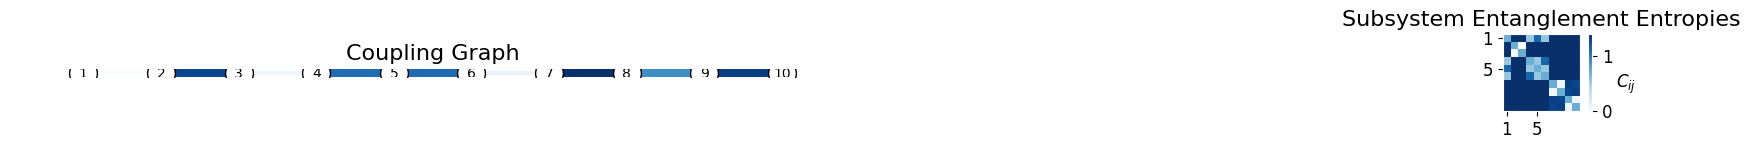

In [16]:
plot_eval_matrix(J, exact_entropy_matrix, title='Subsystem Entanglement Entropies', cmap='Blues', vmin=0.0, vmax=None)

In [17]:
recipes = results // 2
bits = results - 2 * recipes


In [18]:
recipes

array([[0, 2, 2, ..., 2, 1, 2],
       [0, 1, 2, ..., 2, 2, 0],
       [2, 2, 2, ..., 1, 2, 2],
       ...,
       [1, 0, 2, ..., 0, 1, 1],
       [0, 1, 1, ..., 0, 1, 0],
       [1, 1, 0, ..., 1, 1, 0]])

In [19]:
# splits samples into bits (i.e., measurement outcomes) and recipes (measurement bases)
# recipes = samples // 2
# bits = samples - 2 * recipes

# instantiate classical shadow
shadow = qml.ClassicalShadow(bits=bits, recipes=recipes)

In [20]:
from jax import jit
import jax.numpy as jnp

from heisenberg_tutorial.transformer import initialize, preprocess_coupling_matrix

In [21]:
@jit
def _jax_compute_size_one_entropies(x):
    return -jnp.log(jnp.einsum('timl,silm->i', x, x))

@jit
def _jax_compute_size_two_entropies(x):
    return -jnp.log(jnp.einsum('tilm,siml,tjrk,sjkr->ij', x, x, x, x))

def compute_entropies_from_shadow(shadow):
    """
    compute second-order Rényi entanglement entropies for all subsystems of size at most two, using the classical shadow
    protocol
    """
    local_snapshots = shadow.local_snapshots()
    shadow_size = shadow.snapshots

    # compute size two entropies
    entropies = np.array(_jax_compute_size_two_entropies(local_snapshots) + 2 * np.log(shadow_size))

    # compute size one entropies
    entropies_size_one = np.array(_jax_compute_size_one_entropies(local_snapshots) + 2 * np.log(shadow_size))
    np.fill_diagonal(entropies, entropies_size_one)

    return entropies.real

In [22]:
def compute_correlation_matrix_from_shadow(shadow):
    wires = shadow.bits.shape[1]

    qubit_pairs = list(it.combinations(range(wires), r=2))

    correlations = np.zeros((wires, wires))
    np.fill_diagonal(correlations, 1.0)

    for idx, (i, j) in enumerate(qubit_pairs):
        obs = qml.PauliX(i) @ qml.PauliX(j) + qml.PauliY(i) @ qml.PauliY(j) + qml.PauliZ(i) @ qml.PauliZ(j)
        correlations[i, j] = correlations[j, i] = shadow.expval(H=obs, k=1) / 3

    return correlations

In [23]:
predicted_correlation_matrix = compute_correlation_matrix_from_shadow(shadow=shadow)

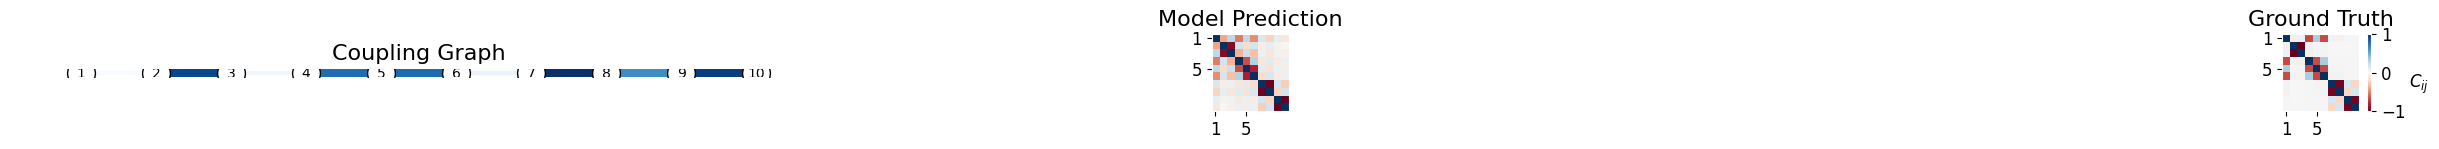

In [24]:
plot_eval_matrix(
    J, predicted_correlation_matrix, true_mat=exact_correlation_matrix, title='Model Prediction', cmap='RdBu'
)